# Problem 3: Catch the Wave

Simulating greedy and Thompson sampling agents on a sinusoidal signal with unknown phase.

**Setup:**
- Signal: $x(\tau) = \cos(2\pi(\tau - \tau_0))$ with 1 Hz frequency
- Phase: $\tau_0 \in \mathcal{Z} = \{0.01, 0.02, \ldots, 0.99, 1.00\}$
- Action: At each integer time $t$, agent selects $A_t \in \mathcal{Z}$
- Observation: $O_{t+1} \sim \text{Bernoulli}\left(\frac{1 + x(t + A_t)}{2}\right)$
- Reward: $R_{t+1} = O_{t+1}$
- Goal: Maximize reward by catching the peak of the wave ($A_t = \tau_0$)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

NUM_SIMS = 200
NUM_TIMESTEPS = 1000
Z = np.round(np.arange(0.01, 1.005, 0.01), 2)  # {0.01, 0.02, ..., 1.00}
NUM_PHASES = len(Z)  # 100

# Pre-generate true phases so both agents face the same environments
np.random.seed(42)
tau0_idxs_shared = np.random.randint(NUM_PHASES, size=NUM_SIMS)

print(f'Phase space Z: {Z[:5]} ... {Z[-5:]}')
print(f'Number of phases: {NUM_PHASES}')
print(f'Simulations: {NUM_SIMS}, Timesteps: {NUM_TIMESTEPS}')

Phase space Z: [0.01 0.02 0.03 0.04 0.05] ... [0.96 0.97 0.98 0.99 1.  ]
Number of phases: 100
Simulations: 200, Timesteps: 1000


## Part 1: Posterior Update Formula

The posterior update follows Bayes' rule:

$$P_{t+1}(z) = \frac{P_t(z) \cdot \mathbb{P}(O_{t+1} \mid \tau_0 = z, A_t)}{\sum_{z' \in \mathcal{Z}} P_t(z') \cdot \mathbb{P}(O_{t+1} \mid \tau_0 = z', A_t)}$$

where the likelihood is:

$$\mathbb{P}(O_{t+1} \mid \tau_0 = z, A_t) = \frac{1 + (2O_{t+1} - 1) \cdot \cos(2\pi(t + A_t - z))}{2}$$

Since $t$ is an integer, $\cos(2\pi(t + A_t - z)) = \cos(2\pi(A_t - z))$, so this simplifies to:

$$\mathbb{P}(O_{t+1} \mid \tau_0 = z, A_t) = \frac{1 + (2O_{t+1} - 1) \cdot \cos(2\pi(A_t - z))}{2}$$

- When $O_{t+1} = 1$: likelihood $= \frac{1 + \cos(2\pi(A_t - z))}{2}$, maximized at $z = A_t$
- When $O_{t+1} = 0$: likelihood $= \frac{1 - \cos(2\pi(A_t - z))}{2}$, maximized at $z = A_t \pm 0.5$

In [2]:
def run_catch_the_wave(agent_type, tau0_idxs, num_sims=NUM_SIMS, num_timesteps=NUM_TIMESTEPS):
    """
    Run the Catch the Wave simulation.

    Parameters
    ----------
    agent_type : str
        'greedy' or 'thompson'
    tau0_idxs : ndarray of int
        Pre-generated true phase indices for each simulation

    Returns
    -------
    regrets : ndarray, shape (num_sims, num_timesteps)
    frac_caught : ndarray, shape (num_timesteps,)
        Fraction of simulations where A_t = tau_0 at each timestep
    caught_wave : ndarray of bool
        Whether each simulation's final action matches the true phase
    """
    regrets = np.zeros((num_sims, num_timesteps))
    action_correct = np.zeros((num_sims, num_timesteps), dtype=bool)

    tau0s = Z[tau0_idxs]

    # Initialize uniform posteriors: shape (num_sims, NUM_PHASES)
    posteriors = np.ones((num_sims, NUM_PHASES)) / NUM_PHASES

    for t in range(num_timesteps):
        # --- Action Selection ---
        if agent_type == 'greedy':
            noise = np.random.rand(num_sims, NUM_PHASES) * 1e-10
            a_idxs = np.argmax(posteriors + noise, axis=1)
        else:  # Thompson sampling
            cumprobs = np.cumsum(posteriors, axis=1)
            cumprobs[:, -1] = 1.0
            u = np.random.rand(num_sims, 1)
            a_idxs = np.argmax(cumprobs >= u, axis=1)

        actions = Z[a_idxs]
        action_correct[:, t] = (a_idxs == tau0_idxs)

        # --- Observation ---
        cos_diff = np.cos(2 * np.pi * (actions - tau0s))
        probs = (1 + cos_diff) / 2
        obs = np.random.binomial(1, probs)

        # --- Regret ---
        regrets[:, t] = (1 - cos_diff) / 2

        # --- Bayesian Posterior Update ---
        signs = (2 * obs - 1)[:, np.newaxis]
        actions_exp = actions[:, np.newaxis]
        cos_vals = np.cos(2 * np.pi * (actions_exp - Z[np.newaxis, :]))
        likelihoods = (1 + signs * cos_vals) / 2

        posteriors *= likelihoods
        posteriors = np.maximum(posteriors, 1e-300)
        posteriors /= posteriors.sum(axis=1, keepdims=True)

    frac_caught = action_correct.mean(axis=0)
    caught_wave = action_correct[:, -1]

    return regrets, frac_caught, caught_wave

## Part 2: Greedy Agent

The greedy agent selects $A_t = \arg\max_z P_t(z)$ (the MAP estimate) at each timestep.
It is initialized with the uniform prior over $\mathcal{Z}$.

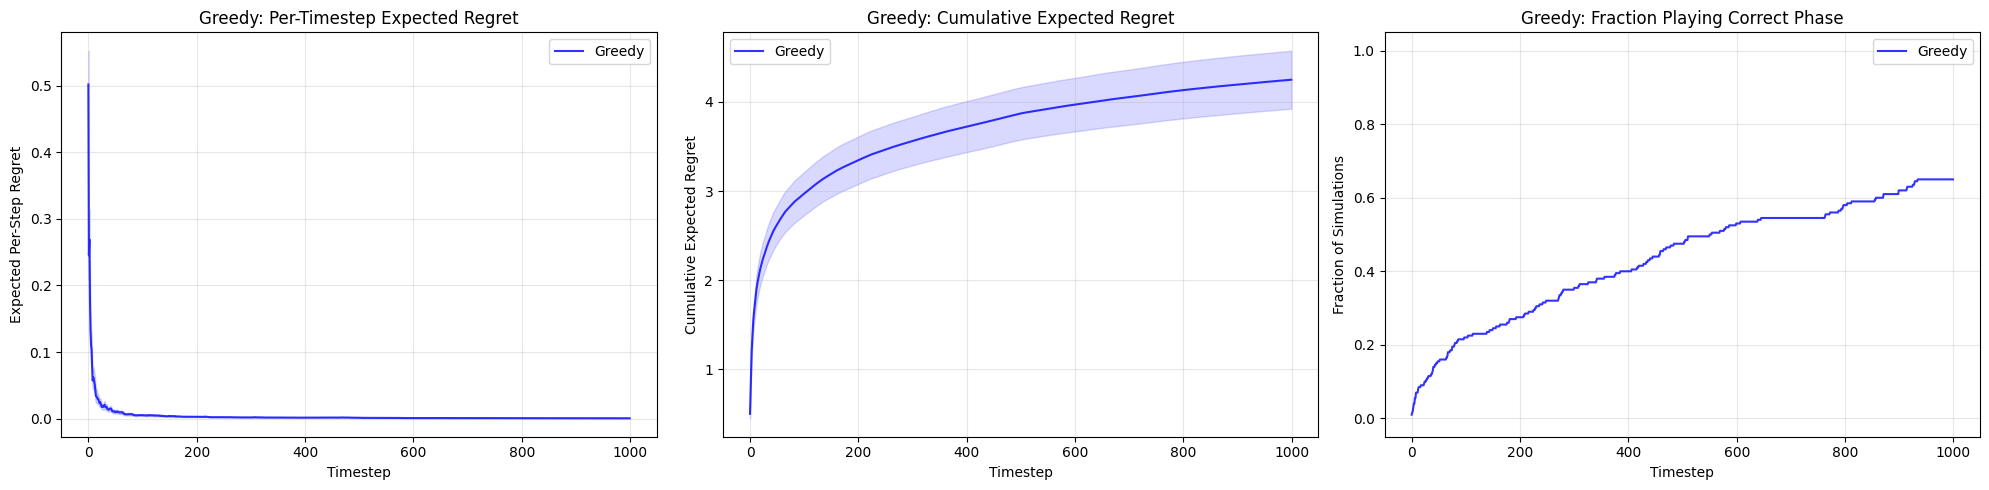

Greedy agent caught the wave: 130/200 (65.0%)
Final per-step regret: 0.000508
Total cumulative regret: 4.25


In [3]:
np.random.seed(100)
greedy_regrets, greedy_frac_caught, greedy_caught = run_catch_the_wave('greedy', tau0_idxs_shared)

# Compute statistics
greedy_avg_regret = np.mean(greedy_regrets, axis=0)
greedy_se_regret = np.std(greedy_regrets, axis=0) / np.sqrt(NUM_SIMS)

greedy_cum_regrets = np.cumsum(greedy_regrets, axis=1)
greedy_avg_cum = np.mean(greedy_cum_regrets, axis=0)
greedy_se_cum = np.std(greedy_cum_regrets, axis=0) / np.sqrt(NUM_SIMS)

timesteps = np.arange(NUM_TIMESTEPS)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Per-timestep regret
axes[0].plot(timesteps, greedy_avg_regret, color='blue', alpha=0.8, label='Greedy')
axes[0].fill_between(timesteps,
                      greedy_avg_regret - 2 * greedy_se_regret,
                      greedy_avg_regret + 2 * greedy_se_regret,
                      color='blue', alpha=0.15)
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Expected Per-Step Regret')
axes[0].set_title('Greedy: Per-Timestep Expected Regret')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative regret
axes[1].plot(timesteps, greedy_avg_cum, color='blue', alpha=0.8, label='Greedy')
axes[1].fill_between(timesteps,
                      greedy_avg_cum - 2 * greedy_se_cum,
                      greedy_avg_cum + 2 * greedy_se_cum,
                      color='blue', alpha=0.15)
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Cumulative Expected Regret')
axes[1].set_title('Greedy: Cumulative Expected Regret')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Fraction catching the wave
axes[2].plot(timesteps, greedy_frac_caught, color='blue', alpha=0.8, label='Greedy')
axes[2].set_xlabel('Timestep')
axes[2].set_ylabel('Fraction of Simulations')
axes[2].set_title('Greedy: Fraction Playing Correct Phase')
axes[2].set_ylim(-0.05, 1.05)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('greedy_catch_wave.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Greedy agent caught the wave: {greedy_caught.sum()}/{NUM_SIMS} ({100*greedy_caught.mean():.1f}%)')
print(f'Final per-step regret: {greedy_avg_regret[-1]:.6f}')
print(f'Total cumulative regret: {greedy_avg_cum[-1]:.2f}')

## Part 3: Thompson Sampling Agent

The Thompson sampling agent samples $A_t \sim P_t$ from the current posterior at each timestep.
It is initialized with the uniform prior over $\mathcal{Z}$.

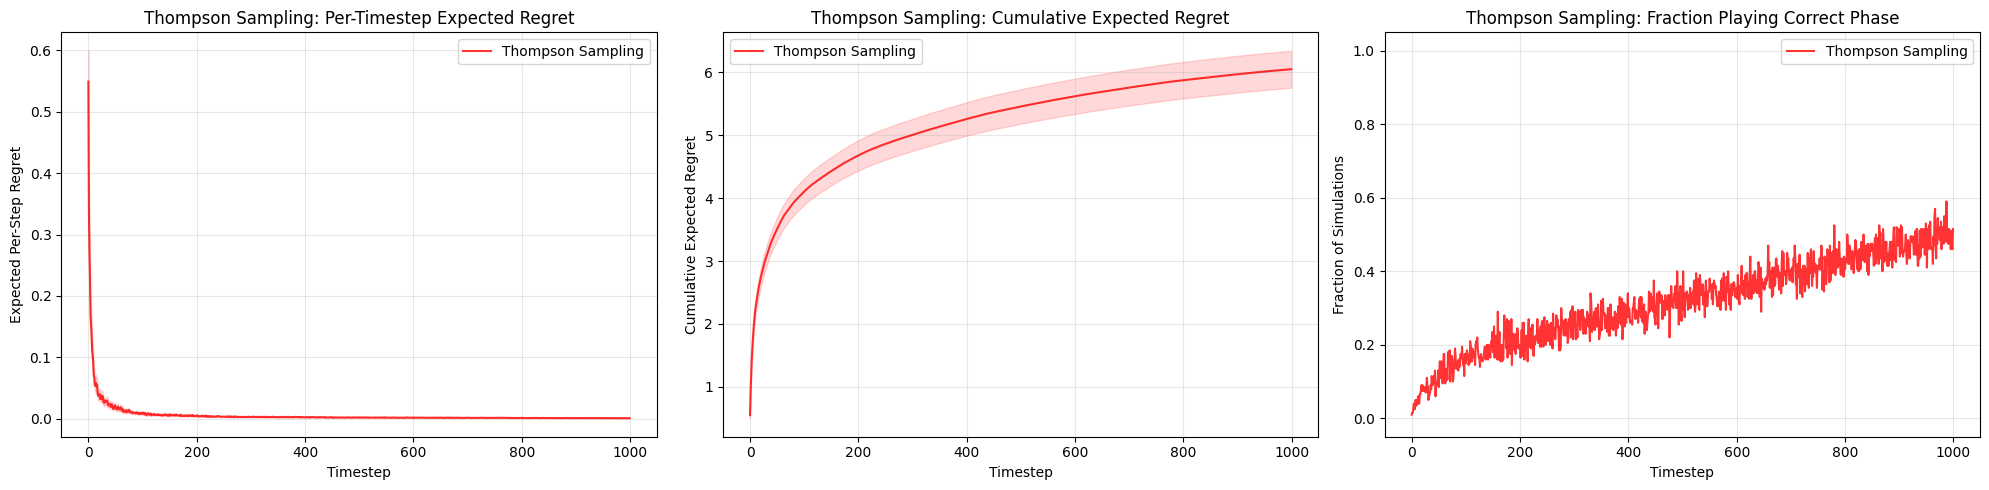

Thompson sampling caught the wave: 103/200 (51.5%)
Final per-step regret: 0.000715
Total cumulative regret: 6.05


In [4]:
np.random.seed(200)
thompson_regrets, thompson_frac_caught, thompson_caught = run_catch_the_wave('thompson', tau0_idxs_shared)

# Compute statistics
thompson_avg_regret = np.mean(thompson_regrets, axis=0)
thompson_se_regret = np.std(thompson_regrets, axis=0) / np.sqrt(NUM_SIMS)

thompson_cum_regrets = np.cumsum(thompson_regrets, axis=1)
thompson_avg_cum = np.mean(thompson_cum_regrets, axis=0)
thompson_se_cum = np.std(thompson_cum_regrets, axis=0) / np.sqrt(NUM_SIMS)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Per-timestep regret
axes[0].plot(timesteps, thompson_avg_regret, color='red', alpha=0.8, label='Thompson Sampling')
axes[0].fill_between(timesteps,
                      thompson_avg_regret - 2 * thompson_se_regret,
                      thompson_avg_regret + 2 * thompson_se_regret,
                      color='red', alpha=0.15)
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Expected Per-Step Regret')
axes[0].set_title('Thompson Sampling: Per-Timestep Expected Regret')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative regret
axes[1].plot(timesteps, thompson_avg_cum, color='red', alpha=0.8, label='Thompson Sampling')
axes[1].fill_between(timesteps,
                      thompson_avg_cum - 2 * thompson_se_cum,
                      thompson_avg_cum + 2 * thompson_se_cum,
                      color='red', alpha=0.15)
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Cumulative Expected Regret')
axes[1].set_title('Thompson Sampling: Cumulative Expected Regret')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Fraction catching the wave
axes[2].plot(timesteps, thompson_frac_caught, color='red', alpha=0.8, label='Thompson Sampling')
axes[2].set_xlabel('Timestep')
axes[2].set_ylabel('Fraction of Simulations')
axes[2].set_title('Thompson Sampling: Fraction Playing Correct Phase')
axes[2].set_ylim(-0.05, 1.05)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('thompson_catch_wave.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Thompson sampling caught the wave: {thompson_caught.sum()}/{NUM_SIMS} ({100*thompson_caught.mean():.1f}%)')
print(f'Final per-step regret: {thompson_avg_regret[-1]:.6f}')
print(f'Total cumulative regret: {thompson_avg_cum[-1]:.2f}')

## Part 4: Comparison

Which agent is more effective in this environment and why?

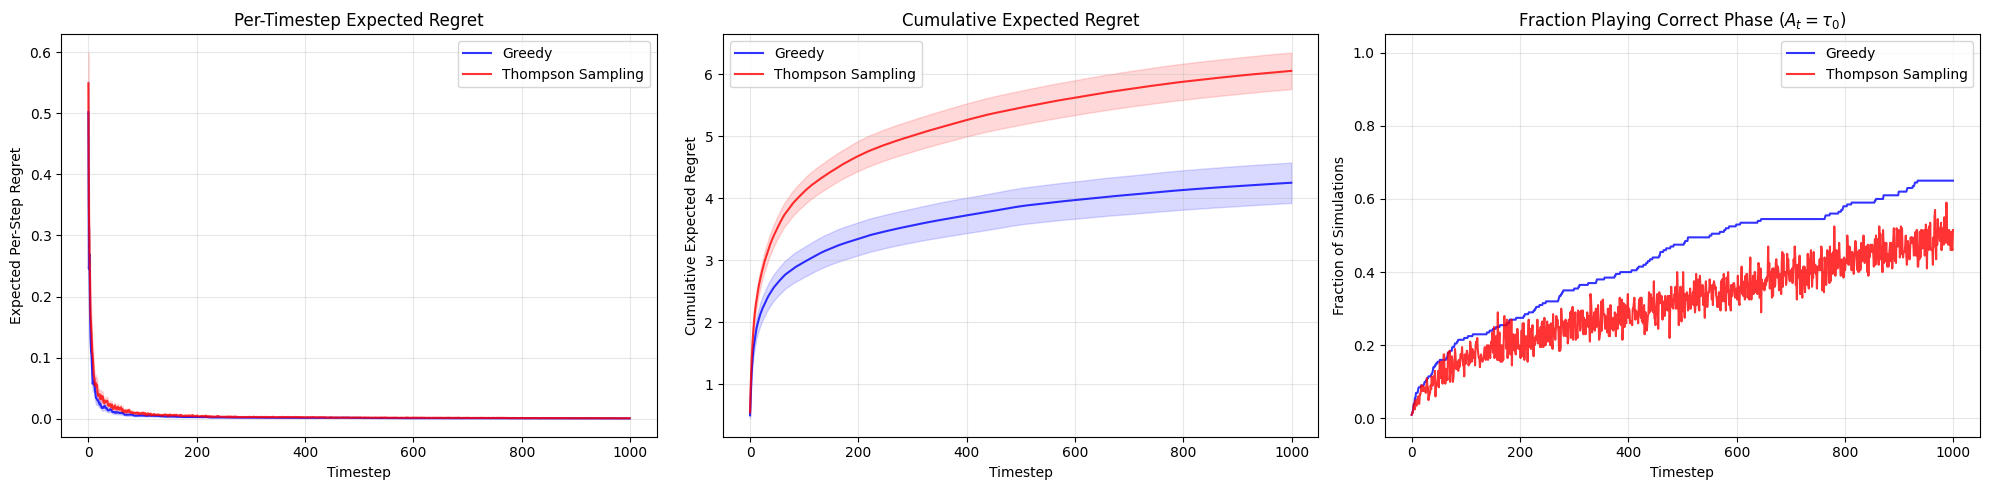

=== Summary ===
Greedy   - Caught wave: 130/200 (65.0%), Cumulative regret: 4.25
Thompson - Caught wave: 103/200 (51.5%), Cumulative regret: 6.05


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Per-timestep regret comparison
axes[0].plot(timesteps, greedy_avg_regret, color='blue', alpha=0.8, label='Greedy')
axes[0].fill_between(timesteps,
                      greedy_avg_regret - 2 * greedy_se_regret,
                      greedy_avg_regret + 2 * greedy_se_regret,
                      color='blue', alpha=0.15)
axes[0].plot(timesteps, thompson_avg_regret, color='red', alpha=0.8, label='Thompson Sampling')
axes[0].fill_between(timesteps,
                      thompson_avg_regret - 2 * thompson_se_regret,
                      thompson_avg_regret + 2 * thompson_se_regret,
                      color='red', alpha=0.15)
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Expected Per-Step Regret')
axes[0].set_title('Per-Timestep Expected Regret')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative regret comparison
axes[1].plot(timesteps, greedy_avg_cum, color='blue', alpha=0.8, label='Greedy')
axes[1].fill_between(timesteps,
                      greedy_avg_cum - 2 * greedy_se_cum,
                      greedy_avg_cum + 2 * greedy_se_cum,
                      color='blue', alpha=0.15)
axes[1].plot(timesteps, thompson_avg_cum, color='red', alpha=0.8, label='Thompson Sampling')
axes[1].fill_between(timesteps,
                      thompson_avg_cum - 2 * thompson_se_cum,
                      thompson_avg_cum + 2 * thompson_se_cum,
                      color='red', alpha=0.15)
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Cumulative Expected Regret')
axes[1].set_title('Cumulative Expected Regret')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Fraction catching the wave comparison
axes[2].plot(timesteps, greedy_frac_caught, color='blue', alpha=0.8, label='Greedy')
axes[2].plot(timesteps, thompson_frac_caught, color='red', alpha=0.8, label='Thompson Sampling')
axes[2].set_xlabel('Timestep')
axes[2].set_ylabel('Fraction of Simulations')
axes[2].set_title('Fraction Playing Correct Phase ($A_t = \\tau_0$)')
axes[2].set_ylim(-0.05, 1.05)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('catch_wave_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('=== Summary ===')
print(f'Greedy   - Caught wave: {greedy_caught.sum()}/{NUM_SIMS} ({100*greedy_caught.mean():.1f}%), '
      f'Cumulative regret: {greedy_avg_cum[-1]:.2f}')
print(f'Thompson - Caught wave: {thompson_caught.sum()}/{NUM_SIMS} ({100*thompson_caught.mean():.1f}%), '
      f'Cumulative regret: {thompson_avg_cum[-1]:.2f}')

### Analysis

**Does the greedy agent catch the wave?**

The greedy agent can catch the wave, but its mechanism for doing so is limited. It always
plays the MAP estimate and can only eliminate a wrong phase $z$ when it observes $O_{t+1} = 0$
while playing $A_t = z$, which sets the posterior $P(\tau_0 = z)$ to zero (since
$P(O=0 \mid \tau_0 = z, A_t = z) = 0$). For nearby wrong phases, the probability of
getting $O=0$ is $(1 - \cos(2\pi \delta))/2 \approx 2\pi^2\delta^2$ for small $\delta$,
which can be very small (e.g., $\approx 0.002$ for $\delta = 0.01$). This means the
greedy agent can take hundreds of steps to eliminate a single adjacent wrong phase.

However, unlike standard multi-armed bandits, each observation here updates the posterior
over ALL phases simultaneously, not just the one being played. This means the greedy agent
gathers useful information even without explicit exploration, and its per-step regret is
small when playing a nearby wrong phase.

**Does Thompson sampling catch the wave?**

Thompson sampling also catches the wave. By sampling actions from the posterior, it naturally
explores different phases. However, this exploration comes at a cost: Thompson sampling
occasionally plays phases far from $\tau_0$, incurring higher per-step regret during
those exploratory steps. As the posterior concentrates, these exploratory deviations
become rarer and the agent converges.

**Which agent is more effective?**

In this environment, both agents eventually catch the wave with vanishing per-step regret.
The greedy agent tends to accumulate lower cumulative regret because it exploits the
MAP estimate rather than exploring. Unlike standard bandit problems where greedy agents
fail due to insufficient exploration, this problem has a structured hypothesis space where
every observation updates all hypotheses simultaneously. The greedy agent's exploitation
is particularly efficient here because:

1. **Structured observations**: Playing any action provides information about ALL phases
   through the Bayesian update, so explicit exploration is less necessary.
2. **Low regret from near-misses**: Even when playing a slightly wrong phase
   ($A_t \approx \tau_0$), the regret $(1 - \cos(2\pi\delta))/2$ is very small.
3. **Elimination property**: Observing $O=0$ while playing $A_t = z$ completely eliminates
   $z$ from the posterior, providing a natural (if slow) exploration mechanism.

Thompson sampling pays an exploration premium that is not fully compensated by faster
phase identification in this structured setting.